# Capstone project - HealthCare Fraud Detection : Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_roc_curve,roc_auc_score,f1_score
from sklearn.metrics import classification_report as cl_rep_skl
from imblearn.pipeline import Pipeline,make_pipeline
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores
from cp_clean_helper import show_values
from LGR_helper import std_num_cols, rb_scale_cols, model_results, get_confusion_matrix
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

### # Loading datasets, dropping few columns, and looking at shapes:-

In [2]:
# Loading datasets

train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)

# Dropping some ID related features and created new model dfs

traindf = train_df.drop(['BeneID','ClaimID','Provider'], axis=1)
testdf = test_df.drop(['BeneID','ClaimID','Provider'], axis=1)

# Looking at dataset shapes

print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)
print('Shape of model train data :',traindf.shape)
print('Shape of model test data :',testdf.shape)

Shape of original train data : (558211, 61)
Shape of original test data : (135392, 60)
Shape of model train data : (558211, 58)
Shape of model test data : (135392, 57)


### # Separating independant and dependant variables:-

In [3]:
## Label Encoding PotentialFraud

label_encoder = preprocessing.LabelEncoder()
traindf['PotentialFraud'] = label_encoder.fit_transform(traindf['PotentialFraud'])

## Separating x and y variables for test train split

LGR_x = traindf.drop(['PotentialFraud'], axis=1)
LGR_y = traindf['PotentialFraud']

In [4]:
LGR_y # 1: Possible-fraud (Yes), 0: Non-fraud (No)

0         1
1         1
2         1
3         1
4         1
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: PotentialFraud, Length: 558211, dtype: int32

In [5]:
LGR_y.value_counts(normalize=True)*100 # Imbalanced classes

0    61.878931
1    38.121069
Name: PotentialFraud, dtype: float64

### # Train-Test split:

In [6]:
# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(LGR_x, LGR_y, random_state=42,\
                                                shuffle=True, stratify=LGR_y, test_size=0.3)

# Looking at dataset shapes

print('\n')
print('Shape of imbalanced trainX data :',trainX.shape)
print('Shape of imbalanced trainY data :',trainY.shape)
print('Shape of imbalanced testX data :',testX.shape)
print('Shape of imbalanced testY data :',testY.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY) :',trainY.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY) :',testY.value_counts(normalize=True)*100)
print('\n')
print("*"*60)



Shape of imbalanced trainX data : (390747, 57)
Shape of imbalanced trainY data : (390747,)
Shape of imbalanced testX data : (167464, 57)
Shape of imbalanced testY data : (167464,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY) : 0    61.878914
1    38.121086
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY) : 0    61.878971
1    38.121029
Name: PotentialFraud, dtype: float64


************************************************************


In [7]:
# Dropping some additional features to evaluate performance

trainX = trainX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                            'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                            'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                            'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

testX = testX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                          'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                          'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                          'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

### # SMOTE Upsampling:

In [8]:
# Upsampling the minority class via SMOTE

trainX_SM, trainY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(trainX, trainY)
testX_SM, testY_SM = SMOTE(random_state=0, k_neighbors=7).fit_resample(testX, testY)

# Upsampling the minority class via Borderline SMOTE

trainX_BSM, trainY_BSM = BorderlineSMOTE(random_state=0).fit_resample(trainX, trainY)
testX_BSM, testY_BSM = BorderlineSMOTE(random_state=0).fit_resample(testX, testY)

# Looking at dataset shapes

print('\n')
print('Shape of SMOTE balanced trainX data :',trainX_SM.shape)
print('Shape of SMOTE balanced trainY data :',trainY_SM.shape)
print('Shape of SMOTE balanced testX data :',testX_SM.shape)
print('Shape of SMOTE balanced testY data :',testY_SM.shape)
print('Shape of Borderline SMOTE balanced trainX data :',trainX_BSM.shape)
print('Shape of Borderline SMOTE balanced trainY data :',trainY_BSM.shape)
print('Shape of Borderline SMOTE balanced testX data :',testX_BSM.shape)
print('Shape of Borderline SMOTE balanced testY data :',testY_BSM.shape, end='\n')
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY_SM) :',trainY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_SM) :',testY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (trainY_BSM) :',trainY_BSM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_BSM) :',testY_BSM.value_counts(normalize=True)*100, end='\n')
print('\n')
print("*"*60)



Shape of SMOTE balanced trainX data : (483580, 44)
Shape of SMOTE balanced trainY data : (483580,)
Shape of SMOTE balanced testX data : (207250, 44)
Shape of SMOTE balanced testY data : (207250,)
Shape of Borderline SMOTE balanced trainX data : (483580, 44)
Shape of Borderline SMOTE balanced trainY data : (483580,)
Shape of Borderline SMOTE balanced testX data : (207250, 44)
Shape of Borderline SMOTE balanced testY data : (207250,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY_SM) : 0    50.0
1    50.0
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY_SM) : 0    50.0
1    50.0
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (trainY_BSM) : 0    50.0
1    50.0
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY_BSM) : 0    50.0
1    50.0
Name: PotentialFraud, dtype: float64


************************************************************


### # Saving the train/test SM/BSM files for future use:

In [9]:
# SMOTE files

# trainX_SM.to_csv('trainX_SM.csv')
# trainY_SM.to_csv('trainY_SM.csv')
# testX_SM.to_csv('testX_SM.csv')
# testY_SM.to_csv('testY_SM.csv')

# BordelineSMOTE files

# trainX_BSM.to_csv('trainX_BSM.csv')
# trainY_BSM.to_csv('trainY_BSM.csv')
# testX_BSM.to_csv('testX_BSM.csv')
# testY_BSM.to_csv('testY_BSM.csv')

### # Standardizing/Robust Scaling the train/test features for base SMOTE Balanced Dataset:

In [10]:
# Unbalanced Dataset

# std_num_cols(trainX)
# std_num_cols(testX)

rb_scale_cols(trainX)
rb_scale_cols(testX)

# SMOTE balanced dataset

# std_num_cols(trainX_SM)
# std_num_cols(testX_SM)

rb_scale_cols(trainX_SM)
rb_scale_cols(testX_SM)

# BorderlineSMOTE balanced dataset

# std_num_cols(trainX_BSM)
# std_num_cols(testX_BSM)

rb_scale_cols(trainX_BSM)
rb_scale_cols(testX_BSM)

## Baseline Logistic Regression Model - Unbalanced Data

In [11]:
# base_logit = LogisticRegression(solver='liblinear')
# model_results(trainX, trainY, testX, testY, base_logit, show=True)

# base_logit = LogisticRegression(solver='liblinear', class_weight='balanced')
# model_results(trainX, trainY, testX, testY, base_logit, show=True)

## Baseline Logistic Regression Model - SMOTE Balanced Data

In [12]:
# First Logistic Regression Baseline Model

# base_logitsm = LogisticRegression(solver='liblinear')
# model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, base_logitsm, show=True)

In [13]:
# Looking at confusion matrix

# get_confusion_matrix(base_logitsm, testX_SM, testY_SM)

# Visualizing the confusion matrix with Yellowbricks

# plt.figure(figsize = (8,8))
# confusion_matrix(
#     base_logitsm,
#     trainX_SM, trainY_SM, testX_SM, testY_SM,
#     classes=['Non-Fraud', 'Possibly-Fraud']
# )

In [14]:
# Looking at classification report

# print(cl_rep_skl(testY_SM, base_logitsm.predict(testX_SM), target_names=['Non-Fraud','Possibly-Fraud']))

# Visualizing the classification report with Yellowbricks

# plt.figure(figsize = (12,6))
# visualizer = classification_report(
#     base_logitsm,
#     trainX_SM, trainY_SM, testX_SM, testY_SM,
#     classes=['Non-Fraud', 'Possibly-Fraud'],
#     cmap='YlGnBu',
#     support=True
# )

In [15]:
# Visualizing the AUC/ROC curve with sklearn function

# plot_roc_curve(base_logitsm, trainX_SM, trainY_SM)

# Visualizing the AUC/ROC curve with Yellowbricks

# plt.figure(figsize = (14,12))

# visualizer = ROCAUC(base_logitsm, classes=['Non-Fraud', 'Possibly-Fraud'])

# visualizer.fit(trainX_SM, trainY_SM)        # Fit the training data to the visualizer
# visualizer.score(testX_SM, testY_SM)        # Evaluate the model on the test data
# visualizer.show()                           # Finalize and render the figure

## Baseline Logistic Regression Model - Borderline SMOTE Balanced Data

In [16]:
# First Logistic Regression Baseline Model

# base_logitbsm = LogisticRegression(solver='liblinear')
# model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, base_logitbsm, show=True)

In [17]:
# Looking at confusion matrix

# get_confusion_matrix(base_logitbsm, testX_BSM, testY_BSM)

# Visualizing the confusion matrix with Yellowbricks

# plt.figure(figsize = (8,8))
# confusion_matrix(
#     base_logitbsm,
#     trainX_BSM, trainY_BSM, testX_BSM, testY_BSM,
#     classes=['Non-Fraud', 'Possibly-Fraud']
# )

In [18]:
# Looking at classification report

# print(cl_rep_skl(testY_BSM, base_logitbsm.predict(testX_BSM), target_names=['Non-Fraud','Possibly-Fraud']))

# Visualizing the classification report with Yellowbricks

# plt.figure(figsize = (12,6))
# visualizer = classification_report(
#     base_logitbsm,
#     trainX_BSM, trainY_BSM, testX_BSM, testY_BSM,
#     classes=['Non-Fraud', 'Possibly-Fraud'],
#     cmap='YlGnBu',
#     support=True
# )

In [19]:
# Visualizing the AUC/ROC curve with sklearn function

# plot_roc_curve(base_logitbsm, trainX_BSM, trainY_BSM)

# Visualizing the AUC/ROC curve with Yellowbricks

# plt.figure(figsize = (14,12))

# visualizer = ROCAUC(base_logitbsm, classes=['Non-Fraud', 'Possibly-Fraud'])

# visualizer.fit(trainX_BSM, trainY_BSM)        # Fit the training data to the visualizer
# visualizer.score(testX_BSM, testY_BSM)        # Evaluate the model on the test data
# visualizer.show()                           # Finalize and render the figure

### # Plotting scores versus different C values

In [20]:
# C_range = [1e8, 1e9, 1e10, 1e11]
# C_range = [0.0001, 0.002]

# train_error = []
# test_error = []
# train_AUC = []
# test_AUC = []
# train_F1 = []
# test_F1 = []

# for C in C_range:
#     logit = LogisticRegression(solver='liblinear')
#     logit.set_params(C=C)
#     logit.fit(trainX_SM, trainY_SM)
#     train_error.append(1 - logit.score(trainX_SM, trainY_SM))
#     test_error.append(1 - logit.score(testX_SM, testY_SM))
#     train_AUC.append(roc_auc_score(trainY_SM, logit.predict(trainX_SM)))
#     test_AUC.append(roc_auc_score(testY_SM, logit.predict(testX_SM)))
#     train_F1.append(f1_score(trainY_SM, logit.predict(trainX_SM)))
#     test_F1.append(f1_score(testY_SM, logit.predict(testX_SM)))

# plt.plot(C_range, train_error, c='red', label='Training Error')
# plt.plot(C_range, test_error, c='blue', label='Test Error')
# plt.ylabel('Errors')
# plt.xlabel('C values')
# plt.legend()
# plt.show()

# plt.plot(C_range, train_AUC, c='red', label='Training AUC Score')
# plt.plot(C_range, test_AUC, c='blue', label='Test AUC Score')
# plt.ylabel('AUC Scores')
# plt.xlabel('C values')
# plt.legend()
# plt.show()

# plt.plot(C_range, train_F1, c='red', label='Training F1 Score')
# plt.plot(C_range, test_F1, c='blue', label='Test F1 Score')
# plt.ylabel('F1 Scores')
# plt.xlabel('C values')
# plt.legend()
# plt.show()

## Using Grid Search to select best parameters:

In [21]:
# Setting x and y variables

x = trainX_SM 
y = trainY_SM

# Setting model required parameters

base_logitsm = LogisticRegression(solver='liblinear', random_state=0)

# Setting the parameter grid

grid_para_logit = [{
    "C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]}]

# Running the RF model through the grid search

grid_search_logit = GridSearchCV(base_logitsm, grid_para_logit,\
                                  cv=5, scoring='f1_weighted',\
                                  return_train_score = True, n_jobs=-1)

grid_search_logit.fit(x, y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000, 1000000,
                                100000000]}],
             return_train_score=True, scoring='f1_weighted')

In [22]:
# The best parameters

grid_search_logit.best_params_

{'C': 0.0001}

In [23]:
# The best score

grid_search_logit.best_score_

0.6667583208541055

In [24]:
# Best estimator training/test errors

print("The training error is: %.5f" % (1 - grid_search_logit.best_estimator_.score(x, y)))
print("The test     error is: %.5f" % (1 - grid_search_logit.best_estimator_.score(testX_SM, testY_SM)))

The training error is: 0.31059
The test     error is: 0.31123


In [25]:
# Selecting the best model from the Grid Search as the final model

final_lgr = grid_search_logit.best_estimator_

# Model with all features and BSM:

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, final_lgr, show=True)

The Model Results for  LogisticRegression(C=0.0001, random_state=0, solver='liblinear')
************************************************************
Train Accuracy is equal to 0.637
Test Accuracy is equal to 0.638
The Precision score is 0.650
The Average Precision score is 0.590
The Recall score is 0.597
The F1 score is 0.622
The AUC/ROC score is 0.638
True-Positive: 61836.000
True-Negative: 70368.000
False-Positive: 33257.000
False-Negative: 41789.000
Correctly Classified: 132204.000
Incorrectly Classified: 75046.000


[0.636630960751065, 0.6378962605548854, 0.6502686843405929, 0.5967285886610374]

In [ ]:
# Visualizing the discrimination threshold

# from yellowbrick.classifier.threshold import discrimination_threshold

# discrimination_threshold(final_lgr, trainX_BSM, trainY_BSM)

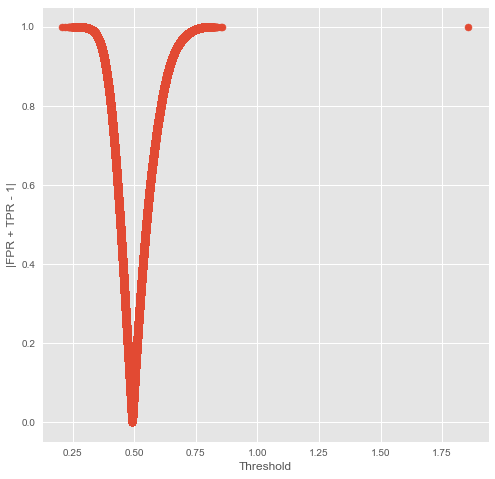

In [40]:
# Visualizing the threshold

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(trainY_BSM,final_lgr.predict_proba(trainX_BSM)[:,1],drop_intermediate=False)

plt.figure(figsize = (8,8))
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [41]:
# Actual value

thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.4917550160946466

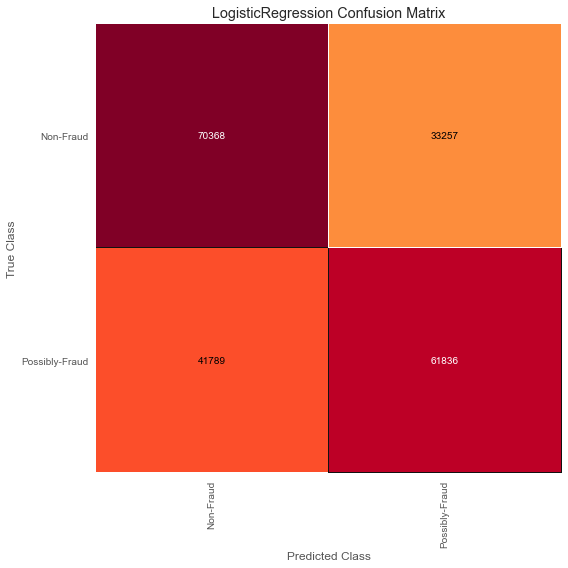

ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['Non-Fraud', 'Possibly-Fraud'],
                cmap=<matplotlib.colors.ListedColormap object at 0x0000012642933580>,
                estimator=LogisticRegression(C=0.0001, random_state=0,
                                             solver='liblinear'))

In [29]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)

plt.figure(figsize = (8,8))
confusion_matrix(
    final_lgr,
    trainX_BSM, trainY_BSM, testX_BSM, testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'])

In [27]:
# Looking at confusion matrix (thres=0.5)

cm1 = get_confusion_matrix(final_lgr, testX_BSM, testY_BSM)

array([[70368, 33257],
       [41789, 61836]], dtype=int64)

In [ ]:
#Plotting the confusion matrix

labels = ['Non-Fraud', 'Possibly-Fraud']

ax = fig.add_subplot(111)
cax = ax.matshow(cm1)
plt.title('Confusion matrix : Threshold - 0.5')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [43]:
# Looking at confusion matrix (thres=0.48)

cm2 = get_confusion_matrix(final_lgr, testX_BSM, testY_BSM, thres=0.48)

array([[57652, 45973],
       [33044, 70581]], dtype=int64)

In [ ]:
#Plotting the confusion matrix

labels = ['Non-Fraud', 'Possibly-Fraud']

ax = fig.add_subplot(111)
cax = ax.matshow(cm2)
plt.title('Confusion matrix : Threshold - 0.48')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

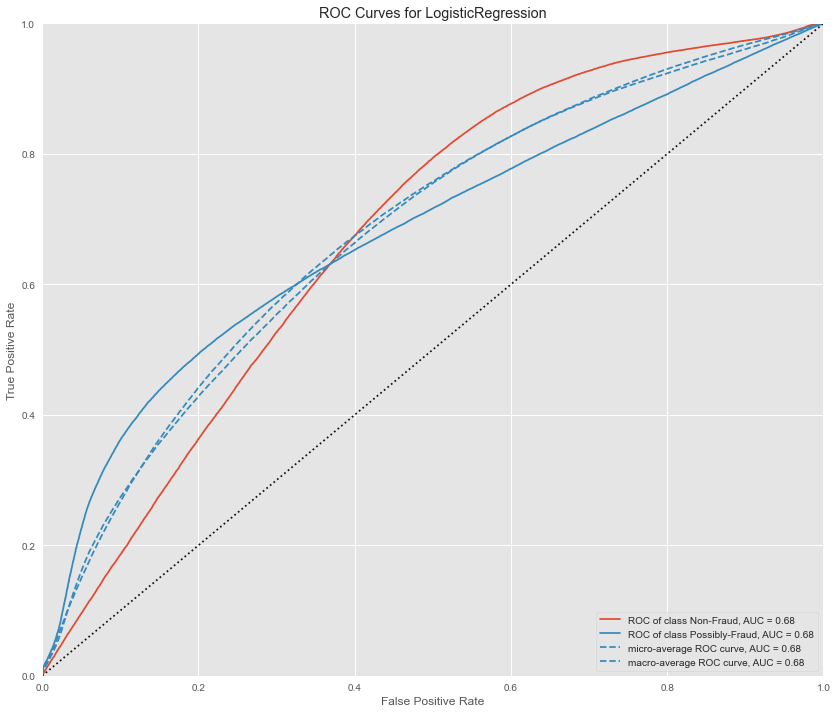

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [31]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))

visualizer = ROCAUC(final_lgr, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_BSM, trainY_BSM)        # Fit the training data to the visualizer
visualizer.score(testX_BSM, testY_BSM)        # Evaluate the model on the test data
visualizer.show()                           # Finalize and render the figure

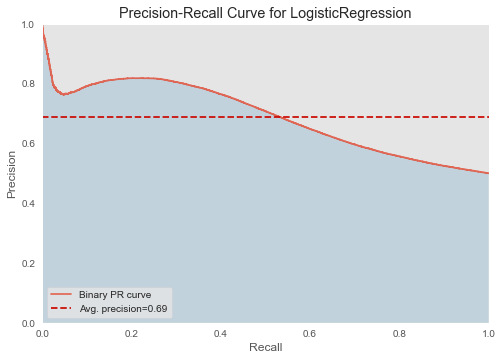

In [32]:
# Visualizing precision-recall curve

from yellowbrick.classifier import precision_recall_curve

plt.figure(figsize = (14,12))
viz = precision_recall_curve(final_lgr, trainX_BSM, trainY_BSM, testX_BSM, testY_BSM)

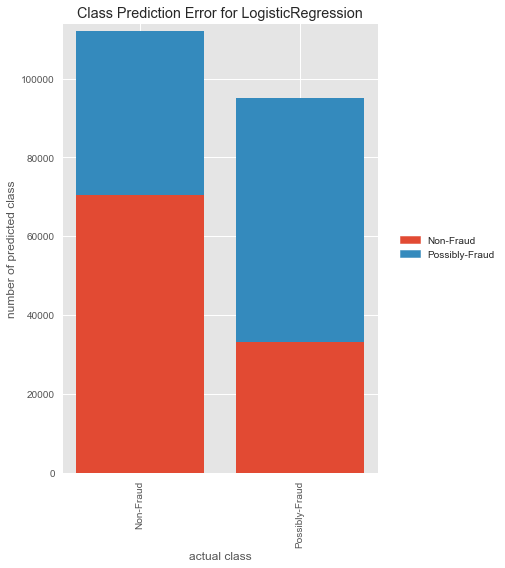

ClassPredictionError(ax=<AxesSubplot:title={'center':'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>,
                     classes=['Non-Fraud', 'Possibly-Fraud'],
                     estimator=LogisticRegression(C=0.0001, random_state=0,
                                                  solver='liblinear'))

In [33]:
# Visualizing prediction error

from yellowbrick.classifier import class_prediction_error

plt.figure(figsize = (8,8))
class_prediction_error(
    final_lgr,
    trainX_BSM, trainY_BSM, testX_BSM, testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'])

## BSM model performs better than SM version

## SHAP Feature Importance Visualization:

### # Variable Importance Plot:

In [1]:
import shap
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(trainX_BSM).toarray()
explainer = shap.Explainer(final_lgr, X_train, feature_names=vectorizer.get_feature_names())
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

NameError: name 'trainX_BSM' is not defined

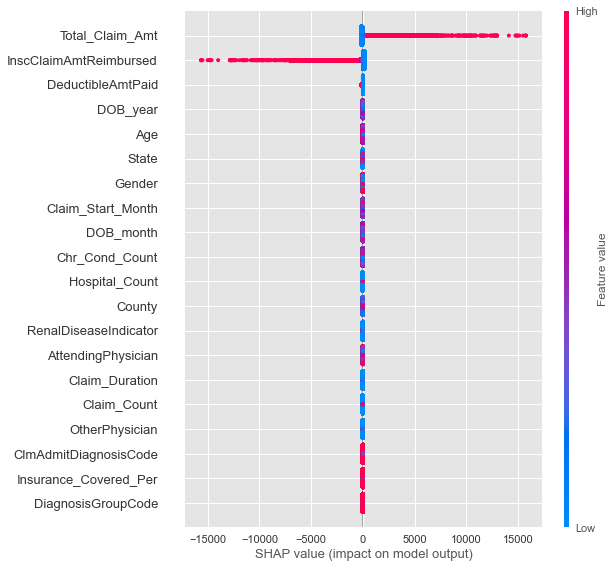

In [45]:
shap.summary_plot(shap_values, X_train)

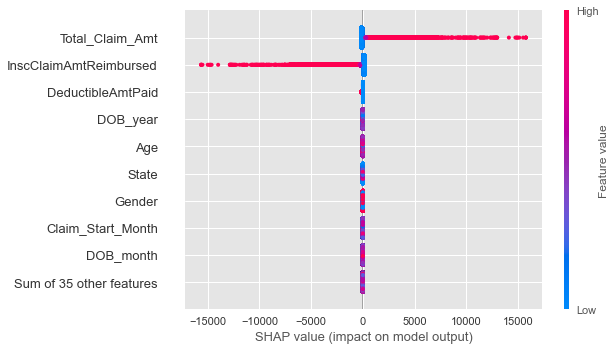

In [46]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

### # SHAP Dependence Plot:

In [53]:
shap.dependence_plot('Total_Claim_Amt', shap_values, X_train)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
shap.dependence_plot('InscClaimAmtReimbursed', shap_values, X_train)

In [ ]:
shap.dependence_plot('DeductibleAmtPaid', shap_values, X_train)

In [ ]:
shap.dependence_plot('Gender', shap_values, X_train)

### # Feature Selection with RFE

In [48]:
from sklearn.feature_selection import RFE

# Extracting top 10 best features with RFE:

rfe = RFE(estimator=final_lgr, n_features_to_select=20, step=10)

# Running model to compare performance

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rfe, show=True)

NameError: name 'RFE' is not defined

In [ ]:
# Looking at RFE feature selection

print(trainX_BSM.columns[rfe.support_])

### # Feature Selection with SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest

# Extracting top 20 best features by applying SelectKBest class

bestfeatures = SelectKBest(k=20)
fit = bestfeatures.fit(trainX_BSM, trainY_BSM)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(trainX_BSM.columns)

#concat two dataframes

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #printing 10 best features

In [ ]:
# Model using SelectKBest 20 features

selected_feat = featureScores.nlargest(20,'Score')['Features'].to_list()

model_results(trainX_BSM[selected_feat], trainY_BSM, testX_BSM[selected_feat], testY_BSM, final_lgr, show=True)